In [1]:
from datasets import SyntheticDataset
from crowd_evaluation import ConfidenceEvaluatorNew, ConfidenceEvaluatorOld, VoteAggregator
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [2]:
from joblib import Memory, Parallel, delayed
memory = Memory('accuracy_vs_spam', verbose=0)

@memory.cache
def calc_fraction_of_wrong_interval_estimates(
        num_samples: int,
        num_workers: int,
        confidence: float,
        evaluator_name: str,
        iter_count: int,
        error_rates: list[float],
        spammer_error_rates: list[float],
        spam_level: float,
        filter: bool,
        filter_threshold: float,
        filter_method: str):

    interval_estimations_accuracy = np.zeros(iter_count, dtype=np.float32)
    average_error_rate_estimation = np.zeros(iter_count, dtype=np.float32)
    average_interval_sizes = np.zeros(iter_count, dtype=np.float32)

    # Saves for every sample generated whether the
    # majority vote estimates the label correctly (=1) or not (=0)

    majority_vote_accuracies = np.zeros(iter_count)
    weighted_vote_accuracies = np.zeros(iter_count)

    majority_vote_estimated_accuracies = np.zeros(iter_count)
    weighted_vote_estimated_accuracies = np.zeros(iter_count)

    majority_vote_guaranteed_accuracies = np.zeros(iter_count)
    weighted_vote_guaranteed_accuracies = np.zeros(iter_count)

    for i in range(iter_count):
        spammer_p_true = np.random.choice(spammer_error_rates, size=num_workers)
        normal_p_true = np.random.choice(error_rates, size=num_workers)
        p_true = np.where(np.random.choice([1, 0], num_workers, p=[spam_level, 1-spam_level]) == 1, spammer_p_true, normal_p_true)
        dataset = SyntheticDataset(num_samples=num_samples, num_workers=num_workers, p_true=p_true)

        if evaluator_name == 'old':
            evaluator = ConfidenceEvaluatorOld(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
                method='greedy'
            )
        else:
            evaluator = ConfidenceEvaluatorNew(dataset)
            ps, confs = evaluator.evaluate_workers_with_confidence(
                dataset.workers,
                confidence=confidence,
            )

        filtered_workers = None
        if filter:
            filtered_workers = VoteAggregator.filter_spammers(dataset.workers, filter_threshold, ps, confs, method=filter_method)

        ps_dict = dict(zip(dataset.workers, ps))
        confs_dict = dict(zip(dataset.workers, confs))


        maj_results, maj_accuracies, maj_overall_accuracy, maj_guaranteed_overall_accuracy = VoteAggregator.majority_vote_with_accuracies(
            dataset=dataset,
            samples=dataset.samples,
            p_ests=ps_dict,
            confidence_intervals=confs_dict,
            confidence_level=confidence,
            selectivity=.5,
            blocked_workers=filtered_workers)

        weighted_results, weighted_accuracies, weighted_overall_accuracy, weighted_guaranteed_overall_accuracy = VoteAggregator.weighted_vote_with_accuracies(
            dataset=dataset,
            samples=dataset.samples,
            p_ests=ps_dict,
            confidence_intervals=confs_dict,
            confidence_level=confidence,
            selectivity=.5,
            blocked_workers=filtered_workers)

        min_limit, max_limit = ps-confs, ps+confs

        interval_estimations_accuracy[i] = np.mean(np.where((min_limit <= p_true) & (p_true <= max_limit), 1, 0))
        average_interval_sizes[i] = np.mean(2*confs)
        average_error_rate_estimation[i] = np.mean(np.abs(ps - p_true))

        truth = dataset.get_ground_truth_for_samples(dataset.samples)
        majority_vote_accuracies[i] = np.count_nonzero(np.where(truth == maj_results, 1, 0)) / len(truth)
        weighted_vote_accuracies[i] = np.count_nonzero(np.where(truth == weighted_results, 1, 0)) / len(truth)

        majority_vote_estimated_accuracies[i] = maj_overall_accuracy
        weighted_vote_estimated_accuracies[i] = weighted_overall_accuracy

        majority_vote_guaranteed_accuracies[i] = maj_guaranteed_overall_accuracy
        weighted_vote_guaranteed_accuracies[i] = weighted_guaranteed_overall_accuracy

    return interval_estimations_accuracy, average_interval_sizes, average_error_rate_estimation, \
           majority_vote_accuracies, weighted_vote_accuracies,\
           majority_vote_estimated_accuracies, weighted_vote_estimated_accuracies, \
           majority_vote_guaranteed_accuracies, weighted_vote_guaranteed_accuracies

In [4]:
from tqdm.notebook import tqdm
import time

spam_levels = np.arange(0, 0.55, 0.1)
spammer_error_rates = [0.40, 0.45, 0.5]
error_rates = [0.05, 0.1, 0.15]
num_workers = 15
num_samples = 300
iteration_count = 100
confidence_level = 0.8

# filtering: bool, filter_threshold: float, filter_method: str
filter_configs = [(False, 0, ''),
                  (True, 0.2, 'normal'), (True, 0.2, 'conservative'), (True, 0.2, 'aggressive')]
                  #(True, 0.1, 'normal'), (True, 0.15, 'normal'),  (True, 0.25, 'normal'),  (True, 0.3, 'normal'), (True, 0.35, 'normal'), (True, 0.4, 'normal')]
                  # (False, 0.1, 'conservative'), (False, 0.15, 'conservative'),  (False, 0.25, 'conservative'),  (False, 0.3, 'conservative'), (False, 0.35, 'conservative'), (False, 0.4, 'conservative'),
                  # (False, 0.1, 'aggressive'), (False, 0.15, 'aggressive'),  (False, 0.25, 'aggressive'),  (False, 0.3, 'aggressive'), (False, 0.35, 'aggressive'), (False, 0.4, 'aggressive')]

average_interval_sizes = dict()
interval_estimations_accuracy = dict()
average_err_est_deviation = dict()

majority_vote_accuracies = dict()
weighted_vote_accuracies = dict()

majority_vote_estimated_accuracies = dict()
weighted_vote_estimated_accuracies = dict()

majority_vote_guaranteed_accuracies = dict()
weighted_vote_guaranteed_accuracies = dict()

for filtering, filter_threshold, filter_method in filter_configs:
    start = time.time()
    print('filtering: ' + str(filtering) + ', filter_threshold: ' + str(filter_threshold) + ', filter_method: ' + filter_method)

    res = Parallel(n_jobs=6)(delayed(calc_fraction_of_wrong_interval_estimates)
            (num_samples, num_workers, confidence_level, 'new', iteration_count, error_rates, spammer_error_rates, spam_level, filtering, filter_threshold, filter_method) for spam_level in tqdm(spam_levels))

    interval_estimations_accuracy[(filtering, filter_threshold, filter_method)] = [np.mean(arr) for arr in np.array([x[0] for x in res])]
    average_err_est_deviation[(filtering, filter_threshold, filter_method)] = [np.mean(arr) for arr in np.array([x[1] for x in res])]
    average_interval_sizes[(filtering, filter_threshold, filter_method)] = [np.mean(arr) for arr in np.array([x[2] for x in res])]

    majority_vote_accuracies[(filtering, filter_threshold, filter_method)] = [np.mean(arr) for arr in np.array([x[3] for x in res])]
    weighted_vote_accuracies[(filtering, filter_threshold, filter_method)] = [np.mean(arr) for arr in np.array([x[4] for x in res])]

    majority_vote_estimated_accuracies[(filtering, filter_threshold, filter_method)] = [np.mean(arr) for arr in np.array([x[5] for x in res])]
    weighted_vote_estimated_accuracies[(filtering, filter_threshold, filter_method)] = [np.mean(arr) for arr in np.array([x[6] for x in res])]

    majority_vote_guaranteed_accuracies[(filtering, filter_threshold, filter_method)] = [np.mean(arr) for arr in np.array([x[7] for x in res])]
    weighted_vote_guaranteed_accuracies[(filtering, filter_threshold, filter_method)] = [np.mean(arr) for arr in np.array([x[8] for x in res])]

    end = time.time()
    print('Elapsed time:', end-start)

filtering: False, filter_threshold: 0, filter_method: 


  0%|          | 0/6 [00:00<?, ?it/s]

Elapsed time: 0.8093523979187012
filtering: True, filter_threshold: 0.2, filter_method: normal


  0%|          | 0/6 [00:00<?, ?it/s]

Elapsed time: 0.019932031631469727
filtering: True, filter_threshold: 0.2, filter_method: conservative


  0%|          | 0/6 [00:00<?, ?it/s]

Elapsed time: 0.016928911209106445
filtering: True, filter_threshold: 0.2, filter_method: aggressive


  0%|          | 0/6 [00:00<?, ?it/s]

Elapsed time: 0.016203880310058594


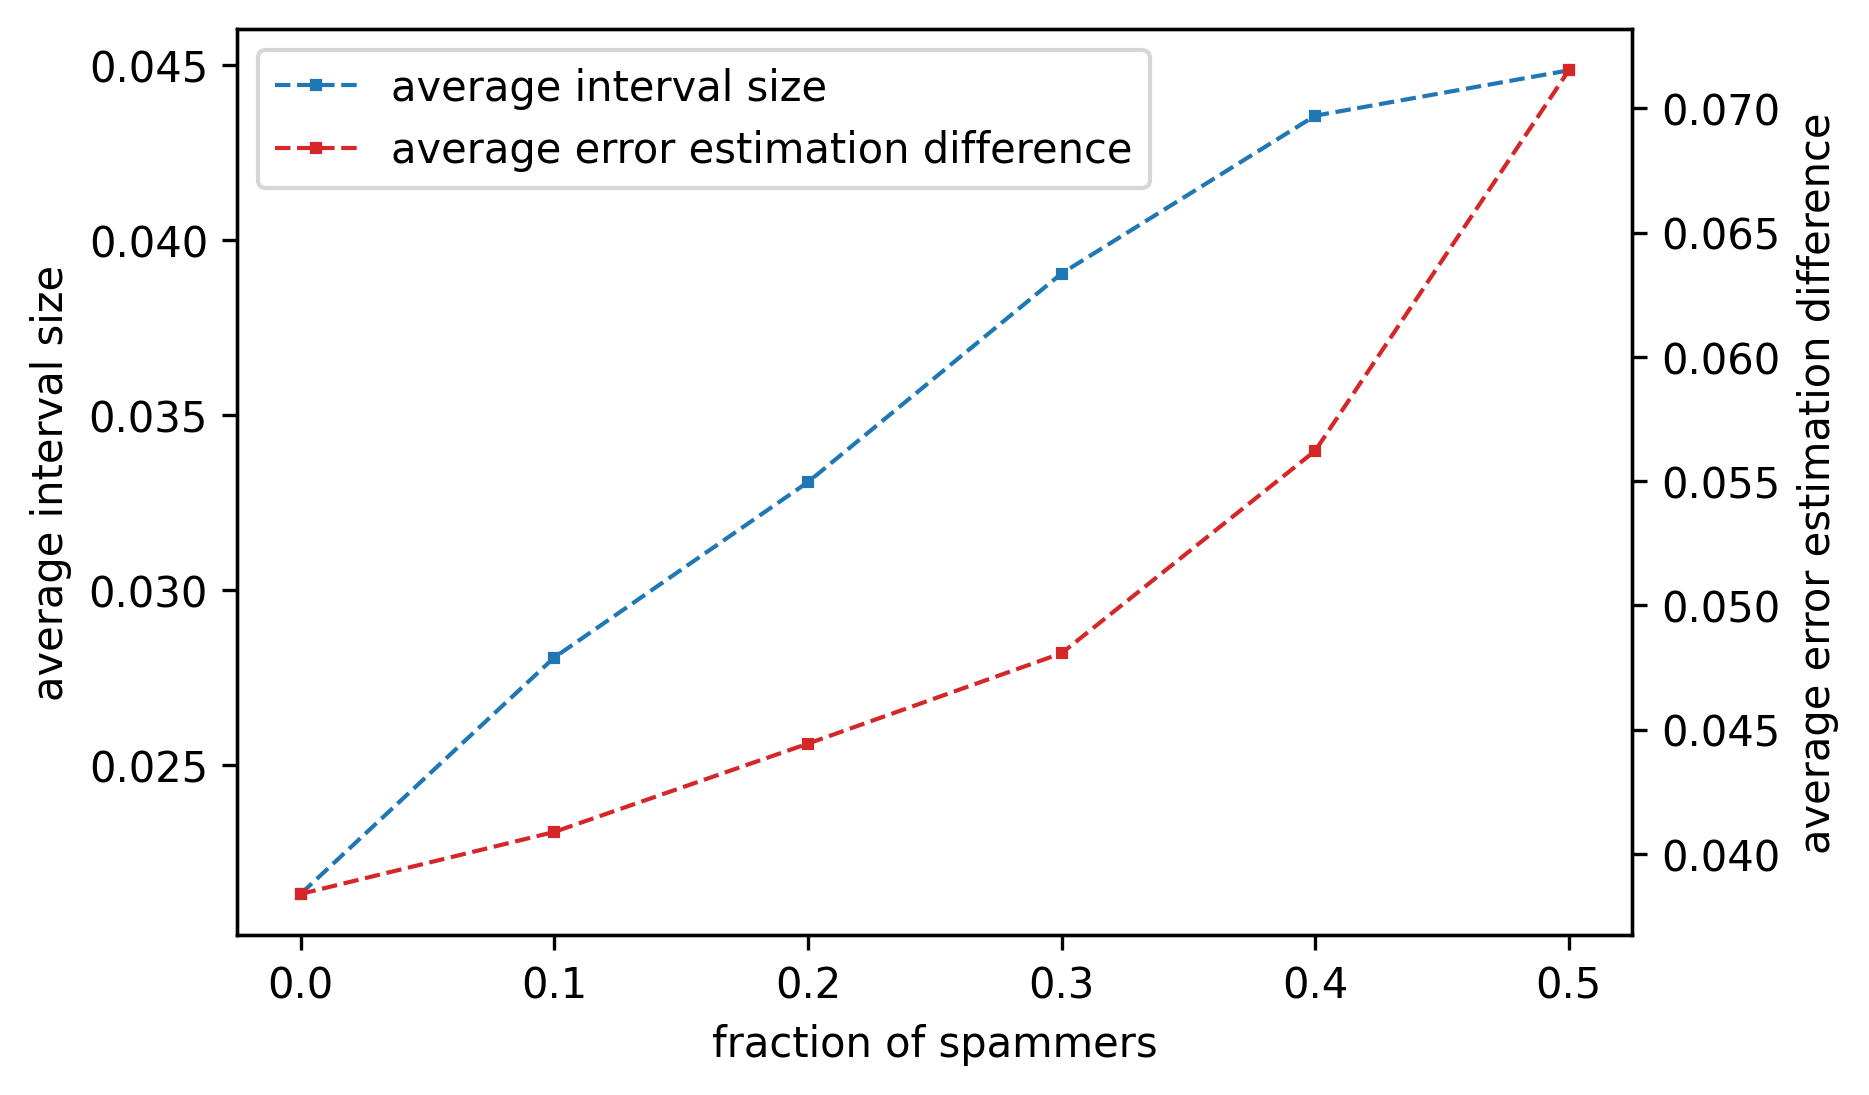

In [5]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('fraction of spammers')
ax1.set_ylabel('average interval size')
lns1 = ax1.plot(spam_levels, average_interval_sizes[(False, 0, '')], label='average interval size',
         color=color, marker='s', linestyle='--', linewidth=1, markersize=2)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('average error estimation difference')  # we already handled the x-label with ax1
lns2 = ax2.plot(spam_levels, average_err_est_deviation[(False, 0, '')], label='average error estimation difference',
         color=color, marker='s', linestyle='--', linewidth=1, markersize=2)

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

In [6]:
 majority_vote_accuracies[(False, 0, '')][-1], weighted_vote_accuracies[(False, 0, '')][-1]

(0.9687666666666667, 0.9943000000000001)

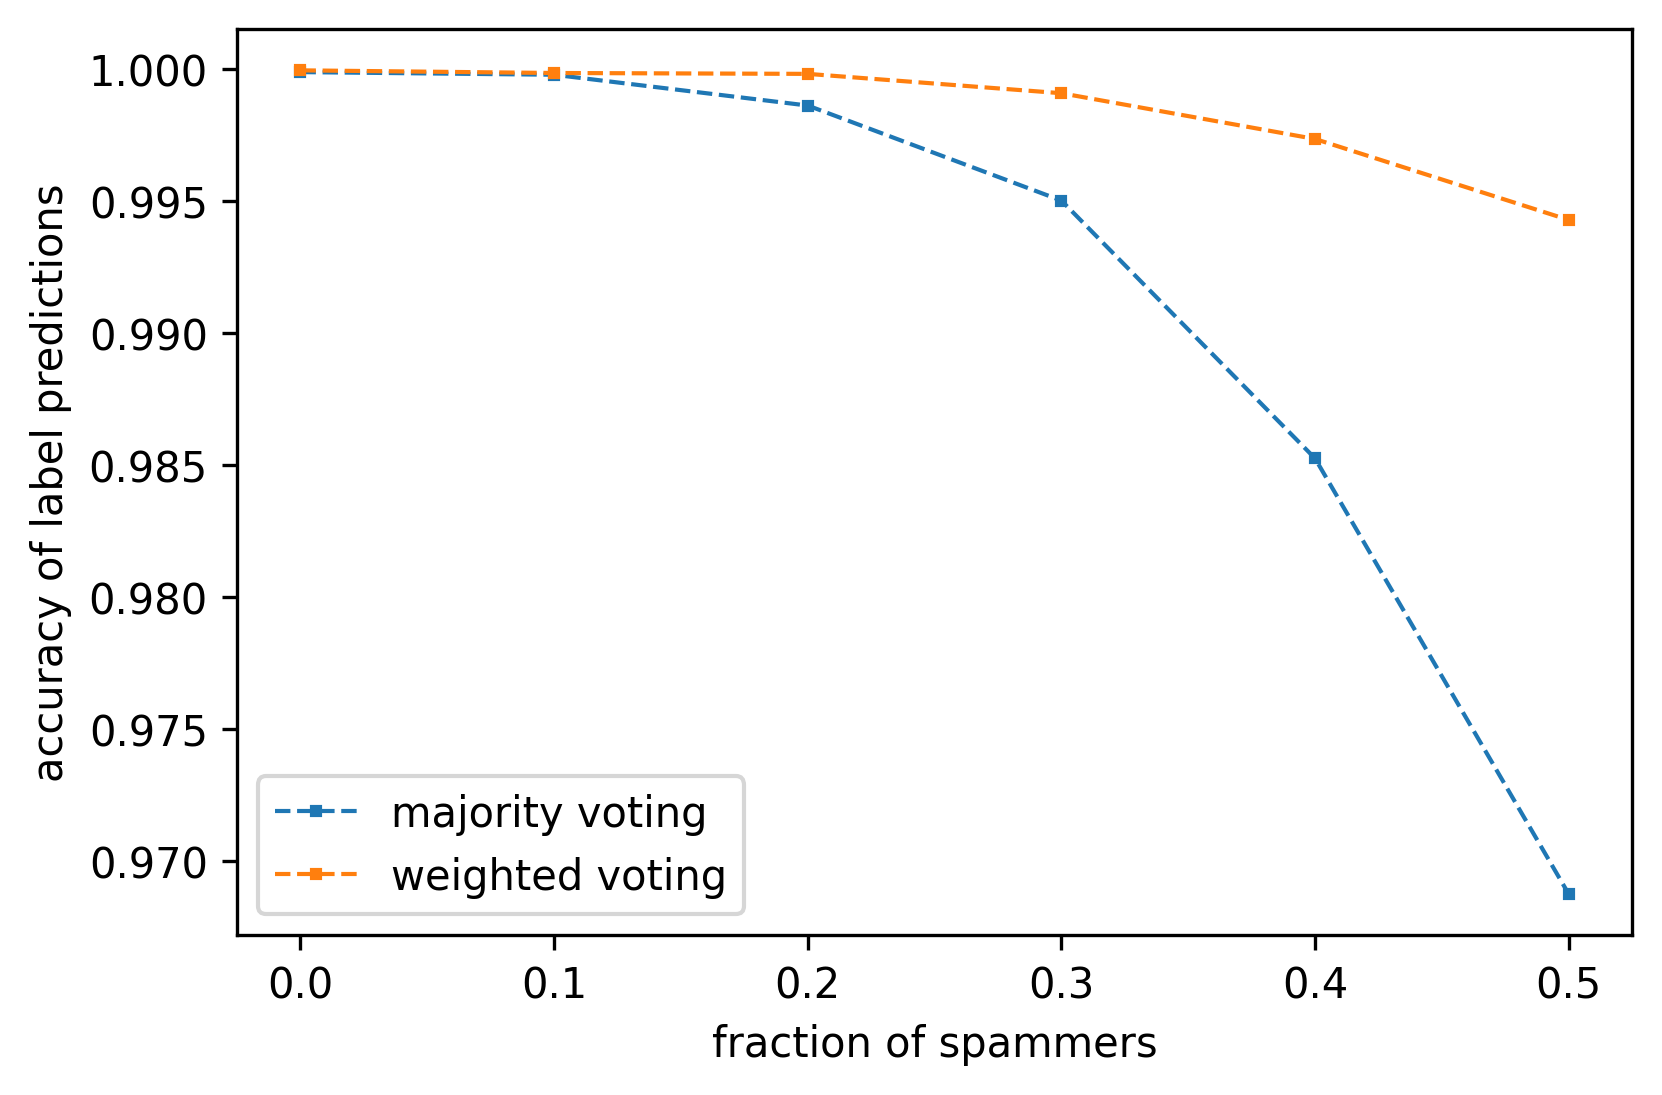

In [7]:
plt.plot(spam_levels, majority_vote_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting')
plt.plot(spam_levels, weighted_vote_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting')

plt.xlabel('fraction of spammers')
plt.ylabel('accuracy of label predictions')
plt.legend(loc='lower left')

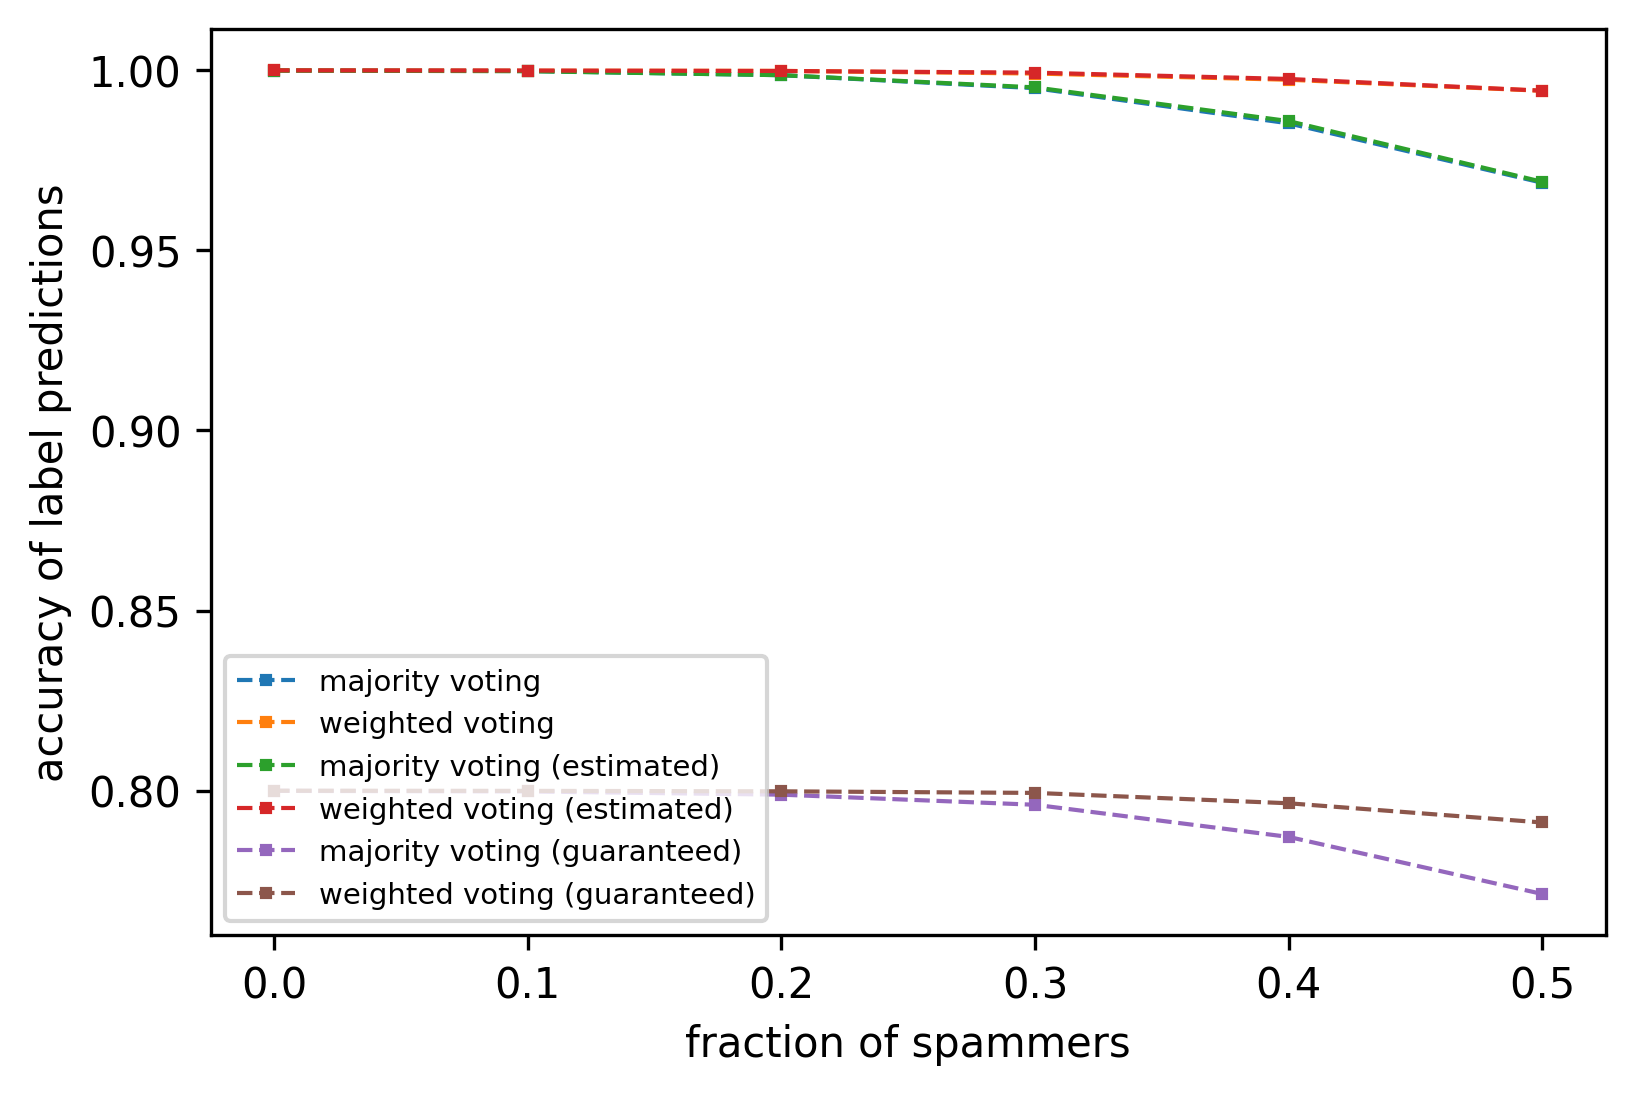

In [8]:
plt.plot(spam_levels, majority_vote_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting')
plt.plot(spam_levels, weighted_vote_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting')

plt.plot(spam_levels, majority_vote_estimated_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (estimated)')
plt.plot(spam_levels, weighted_vote_estimated_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (estimated)')

plt.plot(spam_levels, majority_vote_guaranteed_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (guaranteed)')
plt.plot(spam_levels, weighted_vote_guaranteed_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (guaranteed)')

plt.xlabel('fraction of spammers')
plt.ylabel('accuracy of label predictions')
plt.legend(loc='lower left', prop={'size': 7})

KeyError: (True, 0.1, 'normal')

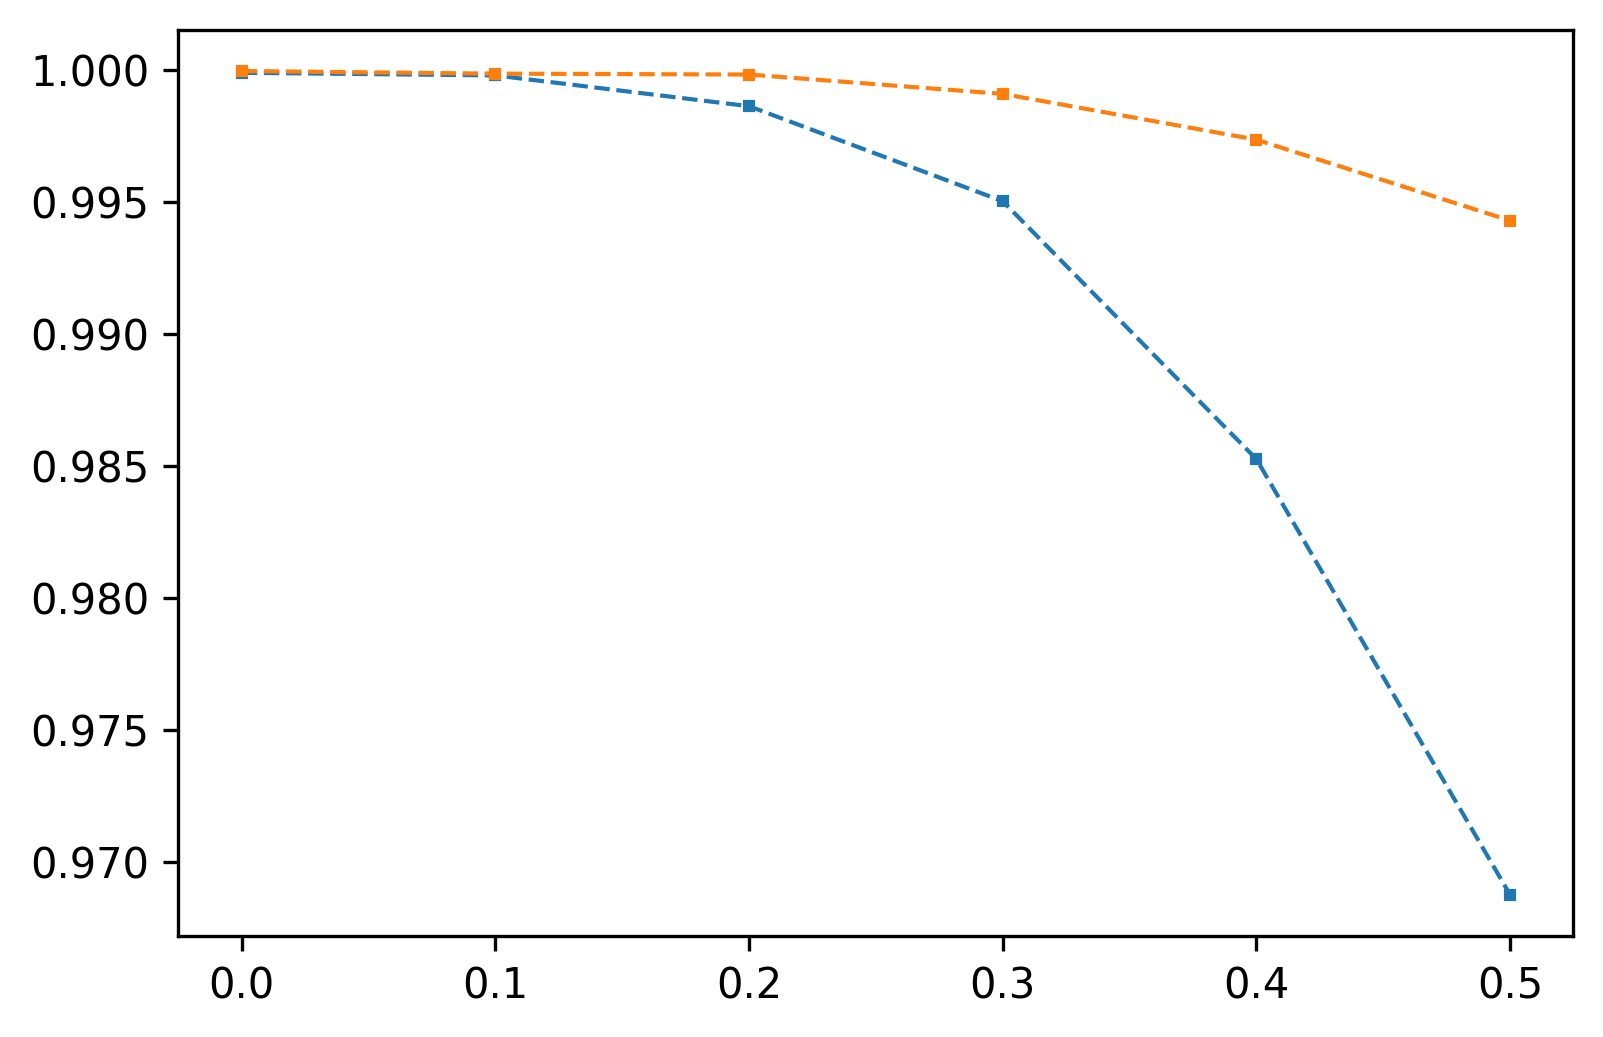

In [9]:
plt.plot(spam_levels, majority_vote_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (no filter)')
plt.plot(spam_levels, weighted_vote_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (no filter)')

plt.plot(spam_levels, majority_vote_accuracies[(True, 0.1, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (0.1)')
plt.plot(spam_levels, weighted_vote_accuracies[(True, 0.1, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (0.1)')

plt.plot(spam_levels, majority_vote_accuracies[(True, 0.2, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (0.2)')
plt.plot(spam_levels, weighted_vote_accuracies[(True, 0.2, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (0.2)')

plt.plot(spam_levels, majority_vote_accuracies[(True, 0.3, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (0.3)')
plt.plot(spam_levels, weighted_vote_accuracies[(True, 0.3, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (0.3)')

plt.plot(spam_levels, majority_vote_accuracies[(True, 0.4, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (0.4)')
plt.plot(spam_levels, weighted_vote_accuracies[(True, 0.4, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting  (0.4)')

plt.xlabel('fraction of spammers')
plt.ylabel('accuracy of label predictions')
plt.legend(loc='lower left', prop={'size': 7})

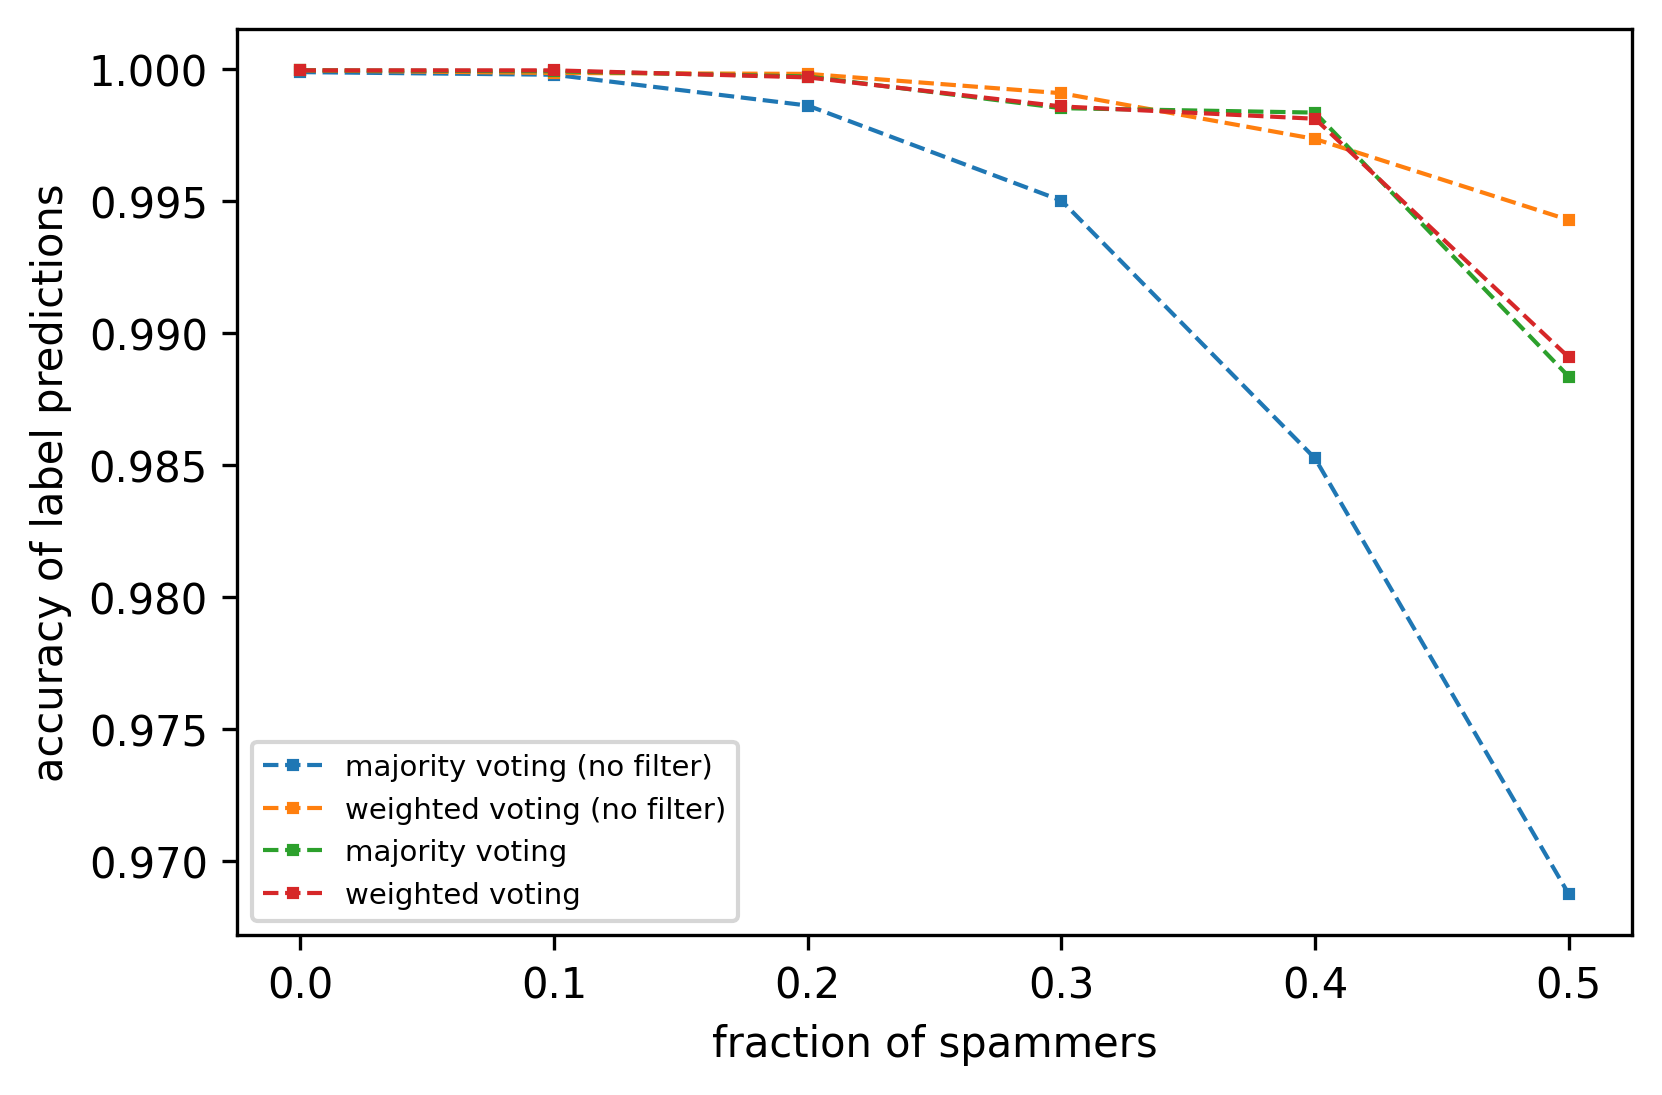

In [11]:
plt.plot(spam_levels, majority_vote_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (no filter)')
plt.plot(spam_levels, weighted_vote_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (no filter)')

plt.plot(spam_levels, majority_vote_accuracies[(True, 0.2, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting')
plt.plot(spam_levels, weighted_vote_accuracies[(True, 0.2, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting')

# plt.plot(spam_levels, majority_vote_estimated_accuracies[(True, 0.2, 'normal')],
#          marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (estimated)')
# plt.plot(spam_levels, weighted_vote_estimated_accuracies[(True, 0.2, 'normal')],
#          marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (estimated)')
#
# plt.plot(spam_levels, majority_vote_guaranteed_accuracies[(True, 0.2, 'normal')],
#          marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (guaranteed)')
# plt.plot(spam_levels, weighted_vote_guaranteed_accuracies[(True, 0.2, 'normal')],
#          marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (guaranteed)')

plt.xlabel('fraction of spammers')
plt.ylabel('accuracy of label predictions')
plt.legend(loc='lower left', prop={'size': 7})

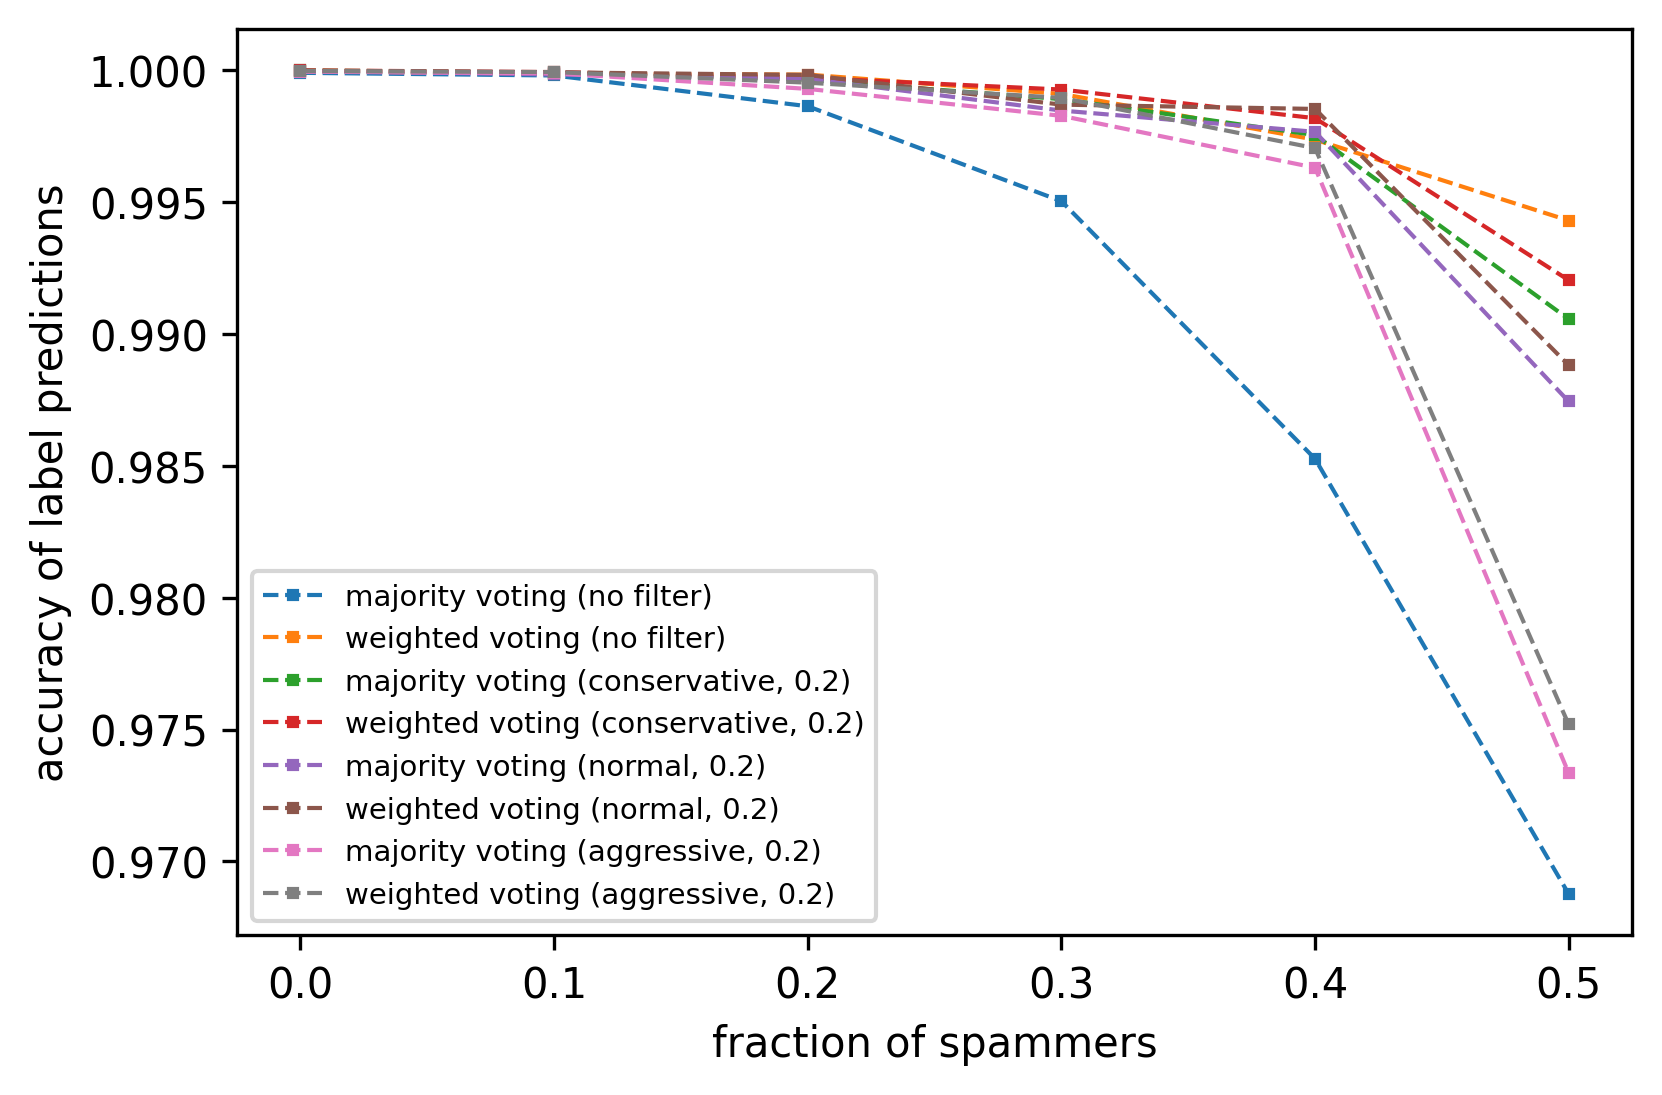

In [10]:
plt.plot(spam_levels, majority_vote_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (no filter)')
plt.plot(spam_levels, weighted_vote_accuracies[(False, 0, '')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (no filter)')

plt.plot(spam_levels, majority_vote_estimated_accuracies[(True, 0.2, 'conservative')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (conservative, 0.2)')
plt.plot(spam_levels, weighted_vote_estimated_accuracies[(True, 0.2, 'conservative')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (conservative, 0.2)')

plt.plot(spam_levels, majority_vote_estimated_accuracies[(True, 0.2, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (normal, 0.2)')
plt.plot(spam_levels, weighted_vote_estimated_accuracies[(True, 0.2, 'normal')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (normal, 0.2)')

plt.plot(spam_levels, majority_vote_estimated_accuracies[(True, 0.2, 'aggressive')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='majority voting (aggressive, 0.2)')
plt.plot(spam_levels, weighted_vote_estimated_accuracies[(True, 0.2, 'aggressive')],
         marker='s', linestyle='--', linewidth=1, markersize=2, label='weighted voting (aggressive, 0.2)')

plt.xlabel('fraction of spammers')
plt.ylabel('accuracy of label predictions')
plt.legend(loc='lower left', prop={'size': 7})